<a href="https://colab.research.google.com/github/azz2k/vendor_challenge/blob/main/vendor_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
* To make my life easier I will remove everything but [a-zA-Z0-9] and whitespaces
* For now I will use a bag-of-words approach as I have limited time

# libraries, constants, etc.

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import sklearn.model_selection

import seaborn as sns
from matplotlib import pyplot as plt

import nltk

This should later be put into: requirements installations (in separate requirements file)

In [2]:
# Punkt sentence tokenizer
nltk.download("punkt")
# Word List Corpus
nltk.download("words")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# read data


In [3]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
products_all_raw_df = pd.read_parquet("/content/drive/MyDrive/Data Science/products.parquet.gz")
products_all_raw_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24
...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,None,22
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22


# look at target

In [5]:
products_all_raw_df["order_count"].describe()

count    633148.000000
mean          9.482963
std          24.025783
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1386.000000
Name: order_count, dtype: float64

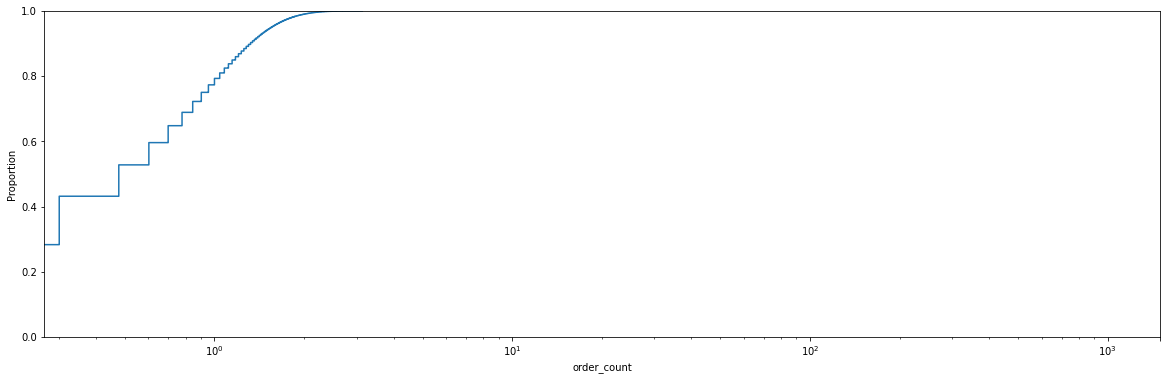

In [6]:
# plot the order count ecdf
fig, ax = plt.subplots(1, 1, figsize = (20, 6))
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax,
    log_scale=True
)
ax.set_xticks([1, 10, 100, 1000, 1500])
plt.show()

That is a target distribution we don't really want to see. Most orders are less than five and only a few orders have a significant number. We need to sample from more than just one month to make useful predictions.

# data cleanup

## train test split

In [7]:
# sample data for testing
products_sample_raw_df = products_all_raw_df.copy() #sample(20000)

In [8]:
# train test split
products_sample_raw_train_df, products_sample_raw_test_df = sklearn.model_selection.train_test_split(products_sample_raw_df, test_size=0.2)

## data normalization

In [9]:
# use these keys to normalize
primary_keys = ["product_id", "vendor_id", "vendor_geohash"]

In [10]:
# split into a more normalized form
products_raw_df = products_sample_raw_train_df[primary_keys + ["order_count"]].copy()
products_name_raw_df = products_sample_raw_train_df[primary_keys + ["product_name"]].copy().rename({"product_name": "text"}, axis=1)
products_description_raw_df = products_sample_raw_train_df[primary_keys + ["product_description"]].copy().rename({"product_description": "text"}, axis=1)

## basic cleanup

In [11]:
products_df = products_raw_df.copy()
products_name_df = products_name_raw_df.copy()
products_description_df = products_description_raw_df.copy()

In [12]:
# drop empty text
products_name_df.dropna(inplace=True)
products_description_df.dropna(inplace=True)

# replace everything but basic chars for now
products_name_df["text"].replace("[^a-zA-Z0-9 ]", " ", inplace=True, regex=True)
products_description_df["text"].replace("[^a-zA-Z0-9 ]", " ", inplace=True, regex=True)

# remove single and double characters
products_name_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_name_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)
products_description_df["text"].replace("(^| )..( |$)", " ", inplace=True, regex=True)

# remove all double whitespaces
products_name_df["text"].replace("[ ]+", " ", inplace=True, regex=True)
products_description_df["text"].replace("[ ]+", " ", inplace=True, regex=True)

# drop empty text
products_name_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_name_df = products_name_df[products_name_df["text"] != ""]

products_description_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_description_df = products_description_df[products_description_df["text"] != ""]

In [13]:
# to lower
products_name_df["text"] = products_name_df["text"].str.lower()
products_description_df["text"] = products_description_df["text"].str.lower()

In [14]:
products_name_df

,product_id,vendor_id,vendor_geohash,text
412979,412979,10303,w21zed3,sliced fish mian
331200,331200,1063,w21zetv,big mac
531398,531398,6648,w21z63v,chicken ham sub
232774,232774,1367,w21zc6u,16 dumpling soup
476988,476988,8749,w21z71p,taro pie
...,...,...,...,...
410370,410370,561,w21z7nq,pineapple juice
146735,146735,8326,w21ze4e,13122096 treats frozen rendang chicken baked g...
619301,619301,912,w23b1s5,box mcnuggets 6pc mcwings 4pc
613170,613170,10040,w21z7k2,tom yum chicken rice bowl


In [15]:
products_description_df

,product_id,vendor_id,vendor_geohash,text
331200,331200,1063,w21zetv,just classic two all 100 beef patties special ...
531398,531398,6648,w21z63v,lean and tender sliced chicken ham with your c...
232774,232774,1367,w21zc6u,traditional dumplings steamy broth comforting ...
199400,199400,12611,w21ze02,smoked salmon overeasy egg mesclun salad avoca...
19473,19473,3309,w21ztq6,pcs
...,...,...,...,...
454183,454183,9364,w21zd1p,ramen inspired dish with fork tender kakuni br...
302821,302821,3929,w23bh0z,beef pepperoni cabanossi ground beef onions gr...
387889,387889,450,w21zezr,satisfy your burning desire for bites with tha...
619301,619301,912,w23b1s5,mcwings chicken mcnuggets now you don have cho...


## tokenization and stemming

In [16]:
products_name_token_df = products_name_df.copy()
products_description_token_df = products_description_df.copy()

In [17]:
# tokenization
products_name_token_df["text_tokens"] = products_name_token_df["text"].transform(nltk.word_tokenize)
products_description_token_df["text_tokens"] = products_description_token_df["text"].apply(nltk.word_tokenize)

In [18]:
# add a position index and explode
products_name_token_df["idx"] = 1
products_name_token_df = products_name_token_df.explode("text_tokens")
products_name_token_df["idx"] = products_name_token_df.groupby(primary_keys)["idx"].cumsum()

products_description_token_df["idx"] = 1
products_description_token_df = products_description_token_df.explode("text_tokens")
products_description_token_df["idx"] = products_description_token_df.groupby(primary_keys)["idx"].cumsum()

In [19]:
# stemming
snowball = nltk.stem.SnowballStemmer(language="english")
products_name_token_df["text_tokens_stemmed"] = products_name_token_df["text_tokens"].apply(lambda x: snowball.stem(x))
products_description_token_df["text_tokens_stemmed"] = products_description_token_df["text_tokens"].apply(lambda x: snowball.stem(x))

## filter english items

The general idea here is to count the fraction of english words in name and description and to use this in some way to filter english items.

### checking if tokens are english and couting etc.

In [20]:
# check if text_tokens are in words corpus
words = nltk.corpus.words.words()
products_name_token_df["is_english"] = products_name_token_df["text_tokens"].isin(words)
products_description_token_df["is_english"] = products_description_token_df["text_tokens"].isin(words)

In [21]:
products_english_df = products_df.copy()

# count english words and total words for product name
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "name_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_name_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "name_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# count english words and total words for product description
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].sum().reset_index().rename({"is_english": "description_is_english"}, axis=1), 
    on=primary_keys, 
    how="left")
products_english_df = products_english_df.merge(
    products_description_token_df.groupby(primary_keys)["is_english"].size().reset_index().rename({"is_english": "description_n_words"}, axis=1), 
    on=primary_keys, 
    how="left")

# replace nans etc. from empty text and cast back to int
for col in ["name_is_english", "name_n_words", "description_is_english", "description_n_words"]:
    products_english_df[col] = products_english_df[col].replace(np.nan, 0).astype(int)

In [22]:
# calculate the actual frequency = score
products_english_df["total_is_english"] = products_english_df["name_is_english"] + products_english_df["description_is_english"]
products_english_df["total_n_words"] = products_english_df["name_n_words"] + products_english_df["description_n_words"]
products_english_df["english_score"] = products_english_df["total_is_english"] / products_english_df["total_n_words"]

In [23]:
# drop ones with no english score
products_english_df = products_english_df[~products_english_df["english_score"].isna()]

### filter metric exploration

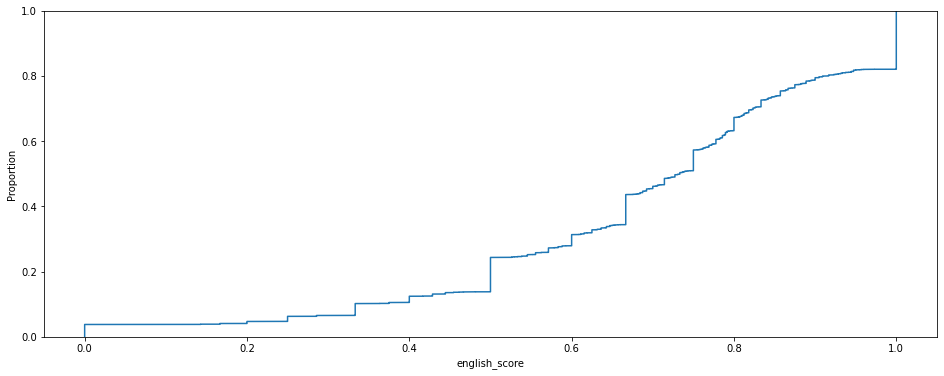

In [24]:
# plot the english score ecdf
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.ecdfplot(
    data=products_english_df,
    x="english_score",
    ax=ax
)
plt.show()

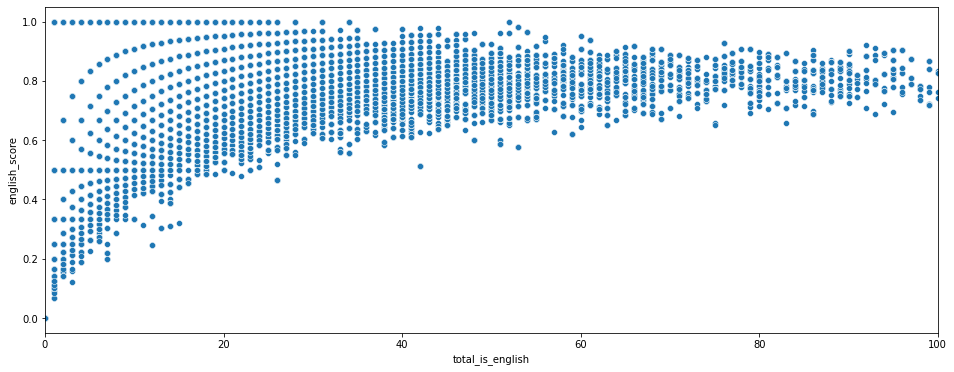

In [25]:
# plot the english score as a function of english words
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.scatterplot(
    data=products_english_df,
    x="total_is_english",
    y="english_score",
    ax=ax
)
ax.set_xlim(0, 100)
plt.show()

In [26]:
products_sample_raw_train_df.merge(products_english_df[(products_english_df["english_score"] > 0.2) & (products_english_df["english_score"] < 0.3)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,330523,8207,w21z9pj,SF YoMate Vanilla Yogurt 哟美香草酸奶 | 150 g,YoMate Vanilla Yogurt,2
1,583345,69,w21zv1d,Brown Brothers Moscato 750ml,,13
2,95331,7738,w21ztrs,61747 Panadol Children's Suspension - Strawber...,None,1
3,197252,6000,w21z70g,SMIRNOFF RED 5CL (5007262),None,1
4,82358,3194,w21zetg,R16. Nasi Udang Kunyit,None,1
...,...,...,...,...,...,...
9282,287641,323,w21zux7,DAYPLUS DBL CHOCOLATE (5000479) | 80 g,None,2
9283,16994,131,w23bhdd,Springfresh Siew Pak Choy 300g,Country of Origin: Malaysia,77
9284,448113,1453,w23b4u6,Mekajiki Sushi,"2 Pcs, swordfish",5
9285,133495,7835,w21z63b,Viking Danish Camembert 125g | 125 piece,Danish Camembert 125g,1


In [27]:
products_sample_raw_train_df.merge(products_english_df[(products_english_df["english_score"] > 0.6) & (products_english_df["english_score"] < 0.7)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,407110,4137,w21z8zg,Ayataka Green Tea 绿茶,None,4
1,24071,63,w21z8uw,100Plus Isotonic Drink 1.5L,,111
2,437331,2960,w21zs27,Lobster Salad Gunkan,None,5
3,445393,3656,w21zv4r,13179226 Coca Cola Original Taste - Less sugar...,None,5
4,337982,2812,w21z6uf,Veggie Deluxe Sub,None,3
...,...,...,...,...,...,...
71437,107075,10900,w23b1ww,Shredded Chicken Macaroni,None,1
71438,433223,5415,w21zwre,931. Shrimps Fried Rice with XO Sauce,None,4
71439,146735,8326,w21ze4e,13122096 Treats Frozen Rendang Chicken Baked G...,None,1
71440,619301,912,w23b1s5,Box B: McNuggets (6pc) + McWings (4pc),McWings® or Chicken McNuggets®? Now you don’t ...,19


In [28]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 0 ][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,19473,3309,w21ztq6,Chwee Kueh,4 Pcs,68
1,131537,5859,w21zg3c,Mee Goreng Pattaya Daging,None,1
2,201633,7145,w21z96w,Cookie (3 Pieces),None,1
3,80259,3938,w23b1ux,Maggi Prata,None,1
4,302724,1306,w21z8gm,Maggi Goreng Ikan Bilis,None,2
...,...,...,...,...,...,...
19274,570622,3241,w21z8zh,Kueh Keria,None,11
19275,425446,6355,w21z8dy,Shizuoka Matcha Latte 静岡の抹茶拿铁,None,4
19276,300312,9069,w21zkpm,Cappuccino,None,2
19277,584855,5154,w23b610,Siew Mai,None,13


In [29]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 1][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,425321,2855,w21z75m,Carrot Halwa,None,4
1,210188,5849,w21ze3t,Smirnoff Red 40% 70cl,None,1
2,26444,1054,w21zuk4,25.Katsu Don 猪扒丼,None,30
3,561318,60,w21z6ey,Fish Briyani,None,11
4,622574,349,w23b1tq,Caramel Latte,None,20
...,...,...,...,...,...,...
57550,370034,3524,w21z7kv,Chicken Murtabak,None,3
57551,471553,7313,w21z836,Dry Bak Kut Teh 干闷特级肉骨茶,None,6
57552,287937,4131,w21z8tp,Hui Fan 烩饭,None,2
57553,579372,659,w21z7qd,Chicken Quesadilla,None,12


In [30]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 2][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,476988,8749,w21z71p,Taro Pie,None,6
1,480114,482,w21z6v7,Tamago Maki,"6 Pcs, omelette",6
2,407110,4137,w21z8zg,Ayataka Green Tea 绿茶,None,4
3,24071,63,w21z8uw,100Plus Isotonic Drink 1.5L,,111
4,437331,2960,w21zs27,Lobster Salad Gunkan,None,5
...,...,...,...,...,...,...
80659,540624,2063,w21z7zj,Spring Roll 春卷,None,9
80660,107075,10900,w23b1ww,Shredded Chicken Macaroni,None,1
80661,312308,5255,w21ze4s,CheezHO Jing Syuan Tea,None,2
80662,373426,2869,w21z8zk,Coffee Pau 咖啡包,1 Pc 1粒,3


In [31]:
products_sample_raw_train_df.merge(products_english_df[products_english_df["total_is_english"] == 3][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,412979,10303,w21zed3,Sliced Fish U Mian,None,4
1,620062,1123,w21ze2c,Sour & Spicy Noodle 酸辣面,None,19
2,334320,7937,w21zg81,NBJ06 Netflix & Chilll'd Pint X 1 | \nChip Hap...,None,3
3,383495,6685,w21zew6,Old Monk Rum | 180 ml,None,3
4,566844,604,w21zscp,Blueberry Green Tea,None,11
...,...,...,...,...,...,...
70486,316163,5945,w21z6zd,GLACEAU VITAMIN WATER RESTORE (5007011) | 500 ml,None,2
70487,453633,5497,w21z3nh,10989836 Anchor Can Beer 320ml x 6's,None,5
70488,493470,2057,w21ztrn,P6. Ham & Mushroom Spaghetti,None,6
70489,421340,1780,w21z3yu,Pop Corn Chicken,None,4


### actual filtering

In [32]:
products_english_filtered_df = products_english_df.copy()
products_english_filtered_df = products_english_filtered_df[products_english_filtered_df["total_is_english"] > 0]

In [33]:
len(products_df), len(products_english_filtered_df)

(506518, 487168)

# cleanup verdict
Obviously we could improve our cleanup and subsequent filtering by a lot.

* better character level cleaning
* better dictionary (also include more culinary terms like croissant, alfredo, pepsi, some basic chinese dishes, etc.)
* english filtering is now only done by number of english words, but other metrics could be better (like and improved version of the english score I tried)

For now it seems to be good enough.

# doc2vec embedding